![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

In [18]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


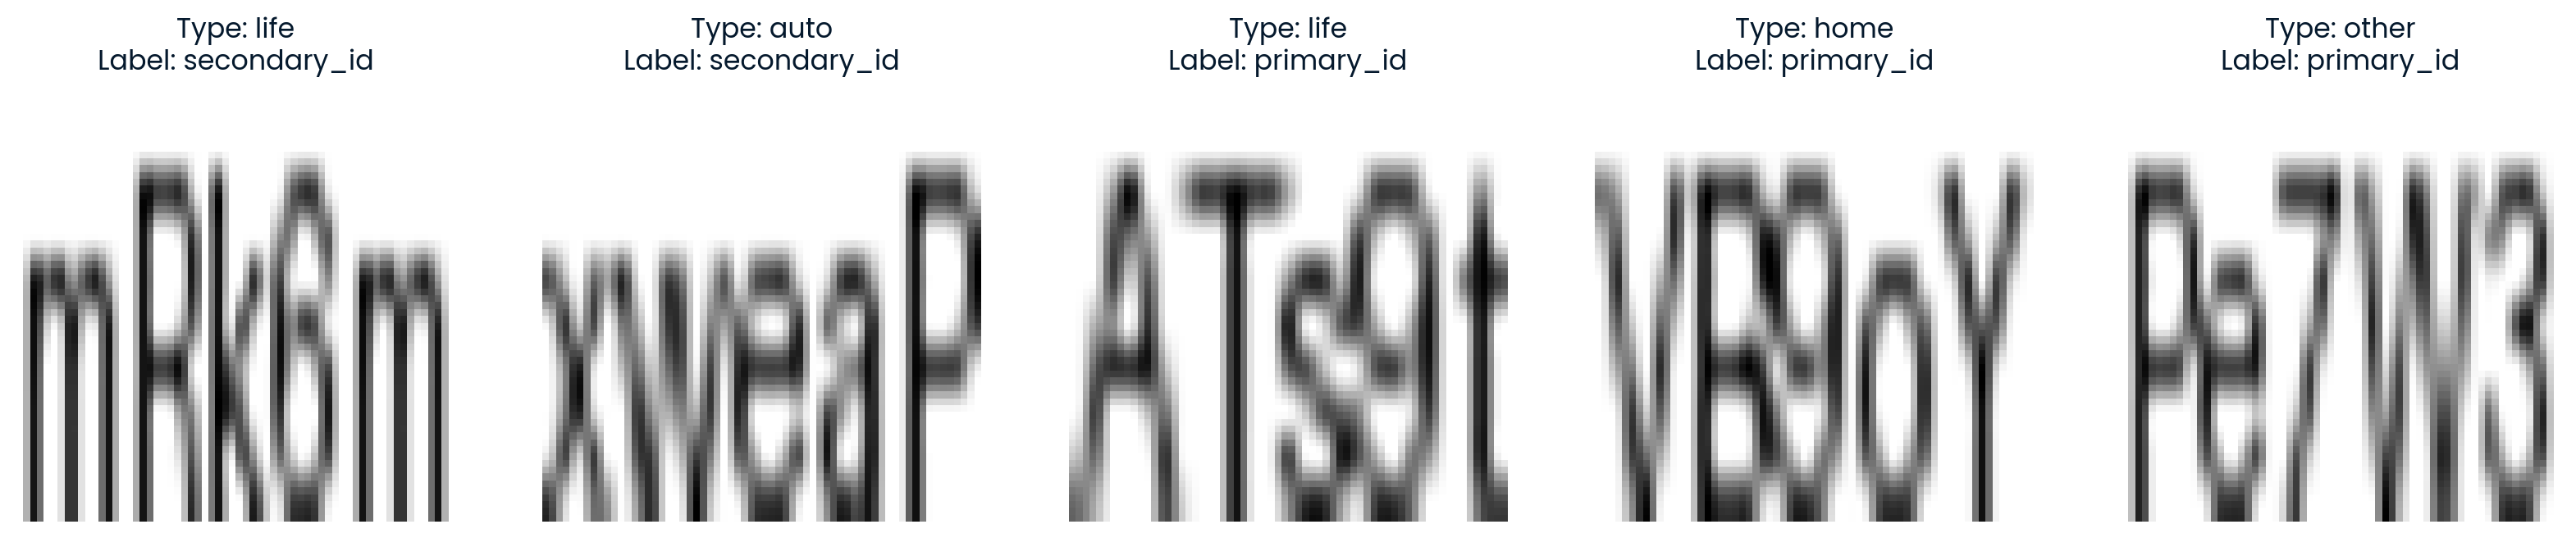

In [19]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [20]:
# Start coding here 

dir(dataset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'data',
 'generate_data',
 'generate_random_string',
 'label_mapping',
 'labels',
 'num_samples',
 'text_to_image',
 'text_type_to_vector',
 'type_mapping']

In [21]:
dataset.data[0][1].shape

torch.Size([5])

In [22]:
class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel,self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*32*32,128)
        )
        self.type_layer = nn.Sequential(
            nn.Linear(5,10),
            nn.ReLU()
            )
        self.classifier = nn.Sequential(
            nn.Linear(128+10,64),
            nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self,x_image,x_type):
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        x = torch.cat((x_image,x_type),dim=1)
        return self.classifier(x)
    
train_dataloader = DataLoader(dataset,batch_size=10, shuffle=True)
model = OCRModel()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
criterion = nn.CrossEntropyLoss()


In [23]:
for epoch in range(10):
    for (images, types), labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images,types)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} produced Loss :{loss.item()}")

Epoch 0 produced Loss :7.262757301330566
Epoch 1 produced Loss :1.0906375646591187
Epoch 2 produced Loss :0.6215165853500366
Epoch 3 produced Loss :0.685451865196228
Epoch 4 produced Loss :0.6878901124000549
Epoch 5 produced Loss :0.6898691058158875
Epoch 6 produced Loss :0.6946482062339783
Epoch 7 produced Loss :0.5585223436355591
Epoch 8 produced Loss :0.42442575097084045
Epoch 9 produced Loss :0.09770049154758453
